In [317]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [318]:
def getRoundedThresholdv1(a, round_step):
    return np.round(a / round_step) * round_step

def produce_plots(data,lb, x_axis='iteration', q1=0.25,q2=0.75):
    q1 = q1
    q2 = q2
    q3 = 0.5
    

    means = data.groupby(x_axis).mean()
    q_lower = data.groupby(by=x_axis).quantile(q=q1,interpolation='lower')
    q_mid = data.groupby(by=x_axis).quantile(q=q3,interpolation='linear')
    q_higher = data.groupby(by=x_axis).quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=means.index, y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax1.plot(q_mid['Loss'], label=f'Median',c='darkorange', lw=0.6)
    ax1.plot(means['Loss'], label='Mean')
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f = plt.figure()
    ax2 = f.add_subplot()

    ax2.fill_between(x=means.index, y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax2.plot(q_mid['C1'], label=f'Median',c='darkorange')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('Iteration')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data['iteration']), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data['iteration']), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    
def plot_separate_trajectories(data, lb, x_axis, alpha=0.5, lw=1, legend=True):
    f = plt.figure()
    ax1 = f.add_subplot()
    f = plt.figure()
    ax2 = f.add_subplot()
    for EXP_NUM in data['trial'].unique():
        traj = data[data['trial'] == EXP_NUM]
        if x_axis == 'time':
            x = traj['time']
        elif x_axis == 'iteration':
            x = traj['iteration']
        if isinstance(alpha, list):
            _a = alpha[EXP_NUM]
        else:
            _a = alpha
        if _a == 0:
            continue
        ax1.plot(x, traj['Loss'], label='Loss - trial {EXP_NUM}', alpha=_a, lw=lw)
        ax2.plot(x, traj['C1'], label=f'C1 - trial {EXP_NUM}', alpha=_a, lw=lw)
    
    ax1.set_xlabel('iteration' if x_axis == 'iteration' else 'time, s')
    # ax1.set_ybound(0, 1)
    ax2.set_xlabel('iteration' if x_axis == 'iteration' else 'time, s')
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data[x_axis]), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data[x_axis]), ls='--', colors='black', alpha=0.5)
    # ax2.set_ybound(-0.02, 0.04)
    ax2.set_ylabel('$L_w-L_b$')
    if legend:
        ax2.legend()
    # f.show()

In [319]:
def produce_plots_time(data, lb, round_step=0.5, fill='bfill', fill_limit=None, q1=0.25,q2=0.75):
    q3 = 0.5
    
    data['time_r'] = getRoundedThresholdv1(data['time'], round_step)
    
    time_step_idx = pd.Index(np.arange(0, max(data['time_r']), step=round_step))
    
    trials = []
    
    for EXP_NUM in data['trial'].unique():
        trial_stats = data[data['trial'] == EXP_NUM]
        trial_stats.index = trial_stats['time_r']
        trial_stats= trial_stats.reindex(time_step_idx, copy=True)
        trial_stats['time_r'] = trial_stats.index
        if fill == 'bfill':
            trial_stats.bfill(inplace=True, limit=fill_limit)
        elif fill == 'ffill':
            trial_stats.ffill(inplace=True, limit=fill_limit)
        else:
            trial_stats.interpolate(fill, inplace=True, limit_direction='forward')
        trials.append(trial_stats)
        
    trials = pd.concat(trials, ignore_index=True)
    trials_gr = trials.groupby('time_r')
    
    # f, axs = plt.subplots(1,5)
    # for EXP_NUM in data['trial'].unique():
    #     axs[EXP_NUM].set_title(EXP_NUM)
    #     tr = trials[trials['trial'] == EXP_NUM]
    #     axs[EXP_NUM].plot(tr['time_r'], tr['Loss'])

    means = trials_gr.mean()
    q_lower = trials_gr.quantile(q=q1,interpolation='lower')
    q_mid = trials_gr.quantile(q=q3,interpolation='linear')
    q_higher = trials_gr.quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=means.index, y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black',lw=0.6)
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black',lw=0.6)
    ax1.plot(q_mid['Loss'], label='Median',c='darkorange')
    ax1.plot(means['Loss'], label='Mean')
    
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('time, s')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f = plt.figure()
    ax2 = f.add_subplot()

    ax2.fill_between(x=means.index, y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax2.plot(q_mid['C1'], label='Median',c='darkorange')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('time, s')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(means.index), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(means.index), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    

In [320]:
TASK = 'income'
STATE = 'ok'

DATASET = TASK +'_'+ STATE
lb = 0.005
geomp = 0.3
sampling = 1
alg = 'aug'

if alg.startswith('sg'):
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{geomp}.csv'
elif alg == 'switch':
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}.csv'
else:
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}.csv'
    
# filename = f'./src/experiments/utils/exp_results/sslalm_employment_az_0.005_1_REPORT.csv'
    
stats = pd.read_csv(filename)
stats_train = stats[stats['is_train'] == 'train'].drop(['is_train'], axis=1)
stats_test = stats[stats['is_train'] == 'test'].drop(['is_train'], axis=1).dropna()
if 'time' in stats_test.columns:
    for trial_num in stats_test['trial'].unique():
        trial_start_time = stats_test.loc[stats_test['trial'] == trial_num].iloc[0]['time']
        stats_test.loc[stats_test['trial'] == trial_num, 'time'] -= trial_start_time

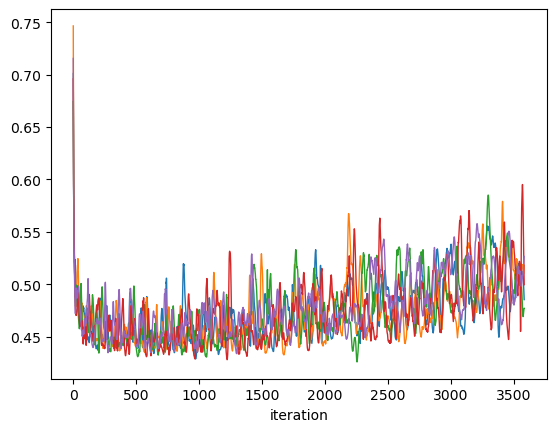

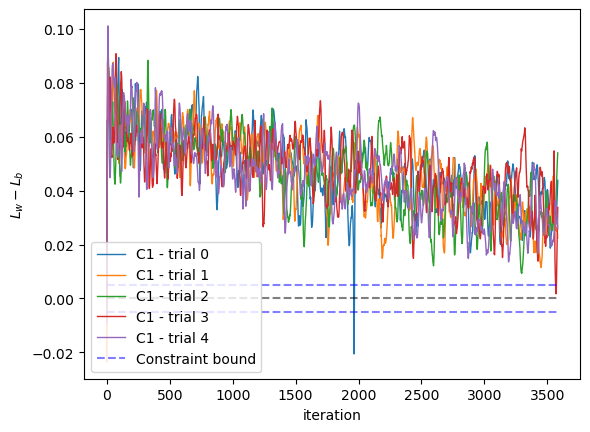

In [321]:
plot_separate_trajectories(stats_train, lb, 'iteration', alpha=1)

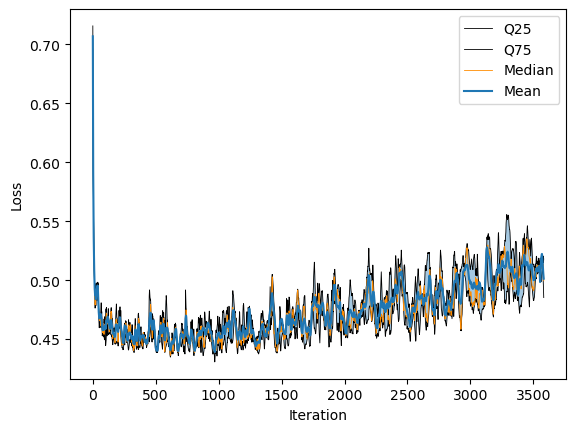

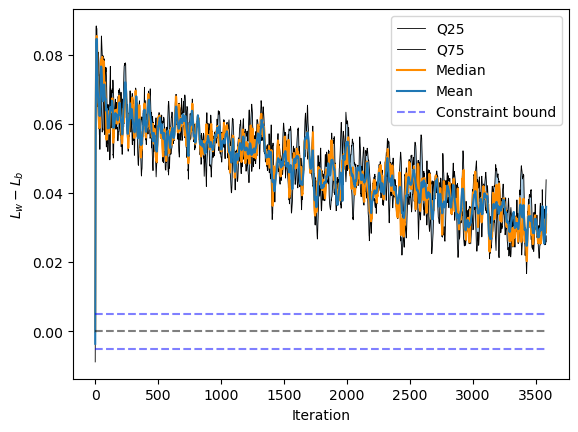

In [322]:
produce_plots(stats_train, lb, 'iteration')

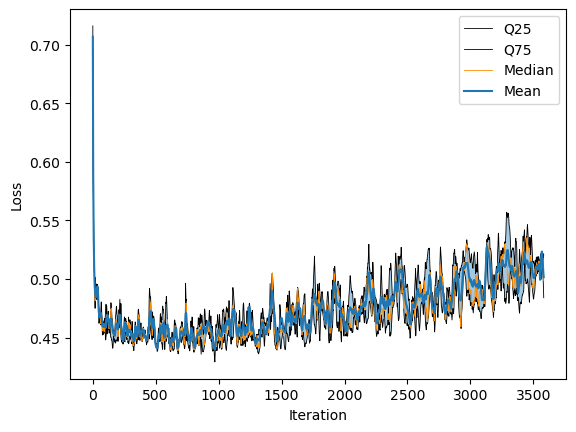

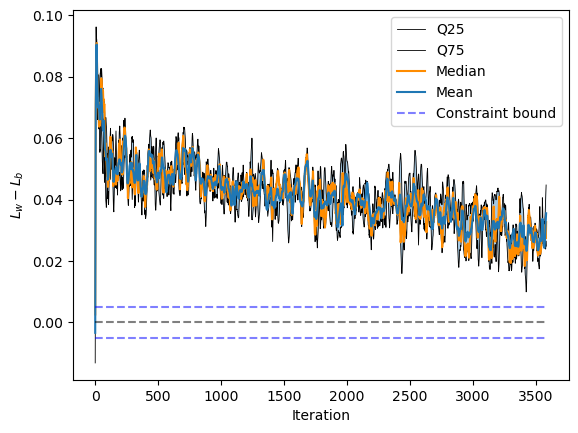

In [323]:
produce_plots(stats_test, lb, 'iteration')

In [324]:
# produce_plots_time(stats_test, lb, fill='ffill', round_step=0.001, q1=0.25, q2=0.75, fill_limit=5)

In [325]:
c_ = pd.read_csv('src/experiments/utils/exp_results/aug_employment_LA_0.005_ctrial.csv')

def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(c_[c_['Unnamed: 0']==0]['0'].to_numpy()))

KeyError: '0'

In [ ]:
stats_test.hist(column='CumSampleSize', bins=10000)

KeyError: "None of [Index(['CumSampleSize'], dtype='object')] are in the [columns]"

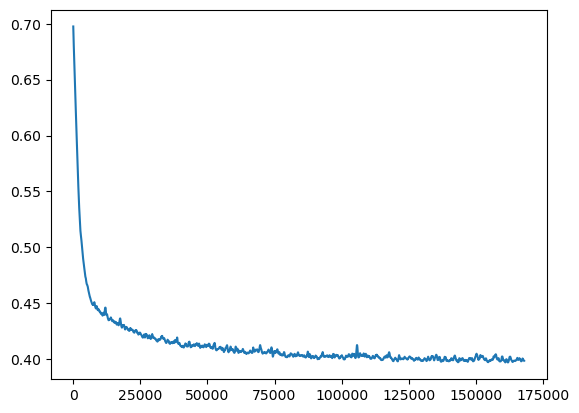

In [ ]:
stats_test['CumSampleSize'] = stats_test.groupby('trial')['SampleSize'].cumsum()
by_css = stats_test.groupby('CumSampleSize')
by_css_mean = by_css.mean()
by_css_qlow = by_css.quantile(q=0,interpolation='lower')
by_css_qupp = by_css.quantile(q=1,interpolation='higher')

f = plt.figure()
ax1 = f.add_subplot()
ax1.plot(by_css_mean['Loss'])

# ax1.fill_between(x=by_css_mean.index.to_numpy(), y1=by_css_qlow['Loss'], y2=by_css_qupp['Loss'],alpha=0.4)
# ax1.plot(by_css_mean.index.to_numpy(), by_css_mean['Loss'])
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qlow['Loss'], c='blue')
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qupp['Loss'],alpha=0.3)